# dtw_main
This jupyter notebook is meant to give the reader an overview of the current state of the project, which (hopefully) will eventually become an academic publication. This Version: June 12, 2019.

## Methodology
This section is based on Franses and Wiemann (2018). 
For an excellent description of the general DTW algorithm, see Müller (2007). Note that unlike Müller (2007), we do not use a quadratic distance function, but instead a growth-based distance function that captures the economic properties of a business cycle. 
Let $\mathbf{x}$ and $\mathbf{y}$ be vectors of dimensions $N$ and $M$, respectively, holding all time series observations of country $x$ and country $y$. Then, our distance function is given by 
$$ d(x_i, y_j) = d_{local}(x_i, y_j) + d_{global}(x_i,y_j) $$

for given time series observations $i \in \{1,\dots,N\}$ and $j \in \{1,\dots,M\}$, respectively, where $x_i$ denotes the $i$-th element of $\mathbf{x}$ and, analogously, $y_j$ denotes the $j$-th element of $\mathbf{y}$. We furthermore define the local feature of observation $i$ of a vector $\mathbf{x}$ that holds $N$ time series observations to be

$$ f_{local}(x_i) = \bigg[ \frac{x_i - x_{i-1}}{x_{i-1}}, \frac{x_{i+1} - x_i}{x_i} \bigg], \qquad i=1,\dots,N. $$

Moreover, the global feature of each observation in $\mathbf{x}$ is given by

$$ f_{global}(x_i) = \Bigg[ \frac{ x_i - (i-1)^{-1}\sum_{k=1}^{i-1}x_k }{ (i-1)^{-1}\sum_{k=1}^{i-1}x_k }, \frac{ x_i - (N - i)^{-1} \sum_{k=i+1}^N x_k }{ (N - i)^{-1} \sum_{k=i+1}^N x_k } \Bigg], \qquad i=1,\dots,N.$$

To overcome the endpoint problem that occurs if $i=1$ or $i=N$, we simply shift the series one element to the right or left, respectively.

Finally, we define $d_{local}(x_i, y_j)$ and $d_{global}(x_i, y_j)$, that constitute $d(x_i, y_j)$:
$$ d_{local}(x_i, y_j) = | f_{local}(x_i)_1 - f_{local}(y_j)_1 | + | f_{local}(x_i)_2 - f_{local}(y_j)_2 |, $$
$$ d_{global}(x_i, y_j) = | f_{global}(x_i)_1 - f_{global}(y_j)_1 | + | f_{global}(x_i)_2 - f_{global}(y_j)_2 |, $$

for $i \in \{1,\dots,N\}$ and $j \in \{1,\dots,M\}$, respectively, and where the subscripts $1$ and $2$ refer to the corresponding elements in the vector.

Concerning the DTW Barycenter Averaging (DBA), we adhere to the algorithm as described in Petitjean et al. (2011) to obtain the centroids required for $k$-Means clustering (see MacQueen et al. (1967) for a first description of $k$-Means clustering). Rather than initializing the clusters of $k$-Means randomly, each of the series has a probability to be assigned as the initial centroid to one of the $k$ clusters in disproportionality to its similarity with the existing centroids. In particular, one of the $G$ considered time series is chosen at random to be the centroid of the first cluster. For the remaining time series, we calculate the probability $p_\ell$:
$$ p_\ell = \frac{ \Gamma^2_\ell }{ \sum_{j=1}^G \Gamma^2_j }, \qquad \ell=1,\dots,G,$$

where $\Gamma_\ell = \sum_{\mathbf{c} \in \mathcal{C}} DTW(\mathbf{x}_\ell, \mathbf{c})$ with $\mathcal{C}$ being the set of existing centroids, $\mathbf{x}_\ell$ the $\ell$-th time series, and DTW the Dynamic Time Warping distance as defined in Müller (2007). A time series $\ell$ is selected as the centroid for the next cluster with probability $p_\ell$, and the step is repeated until all clusters are assigned to an initial centroid. The remaining time series are then grouped into the cluster with the 'closest' centroid as assessed by the DTW distances.
All of these steps are implemented in the functions contained in `dtw_funs.py`.

## Data Import and Preparation
Load the alreday pre-processed data. We transformed the GDP growth data to GDP index data, where we set 1960=100 for all countries.

In [1]:
import numpy as np 
import dtw_funs as dtw # written by me
import matplotlib.pyplot as plt
import pathlib as pl
import pandas as pd 
import seaborn as sns

data_df   = pd.read_csv('/Users/mwelz/Documents/work/ra_franses/2019/wk17/data/africa_gdp_index.csv', header=0)
data_df.drop(data_df.tail(4).index,inplace=True) # drop last 4 rows (constant growth everywhere)
del data_df['DATE'] # drop dates from data frame
print(data_df.head(5))

      ALGERIA      ANGOLA       BENIN    BOTSWANA  BURKINAFASO     BURUNDI  \
0  100.000000  100.000000  100.000000  100.000000   100.000000  100.000000   
1   86.400000  100.000000  103.100000  106.300000   104.000000   86.300000   
2   69.379200  105.200000   99.594600  113.422100   110.344000   94.153300   
3   93.176266  114.878400  104.275546  120.114004   108.909528   98.013585   
4   98.580489  126.940632  111.262008  128.281756   111.414447  104.188441   

    CABOVERDE    CAMEROON         CAR        CHAD     ...      SIERRALEONE  \
0  100.000000  100.000000  100.000000  100.000000     ...       100.000000   
1  100.000000  101.200000  105.000000  101.400000     ...       101.800000   
2  104.500000  104.236000  101.115000  106.875600     ...       106.381000   
3  105.127000  108.092732  100.407195  105.165590     ...       108.189477   
4  120.265288  111.875978  102.515746  102.536451     ...       115.438172   

      SOMALIA  SOUTHAFRICA       SUDAN    TANZANIA        TOGO

### Data Visualization
Visualize the data to see that we need to drop Botswana and Equatorial Guinea as they are outlying. Keeping them might result in spurious clusters that only contain these two countries because of their sheer magnitude and not because of their economic similarity.

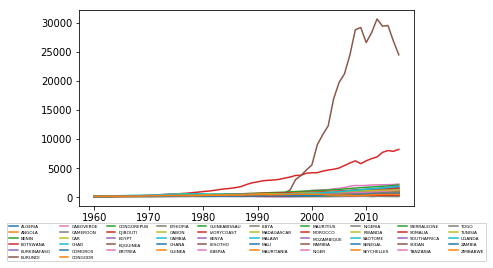

In [2]:
%matplotlib inline

countries = list(data_df)
X         = data_df.values
x         = 1960 + np.arange(np.shape(X)[0]) # x-axis
 
plots     = []
f         = plt.figure()
ax        = plt.subplot(111)
for i in np.arange(np.shape(X)[1]):
    country = countries[i]
    plots.append(plt.plot(x, X[:,i], label = country))
    
# Shrink current axis' height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.075), ncol = 10, prop = {'size': 4.3})
plt.show()
plt.close(f)

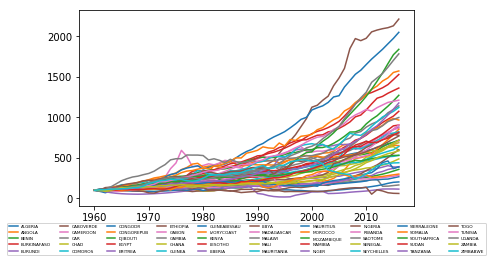

In [3]:
# Without Botswana and Equatorial Guinea:
plots = []
f     = plt.figure()
ax    = plt.subplot(111)
for i in np.arange(np.shape(X)[1]):
    country = countries[i]
    if (country == 'BOTSWANA') or (country == 'EQGUINEA'): 
        continue
    plots.append(plt.plot(x, X[:,i], label = country))

# Shrink current axis' height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.075), ncol = 10, prop = {'size': 4.3})
plt.show()
plt.close(f)

## DTW Mapping
Use DTW to map each time series observation of a country to a time series observation of another country. Here, we will only map Algeria against Angola to avoid an overwhelming amount of plots. If you want to map all countries against each other, I recommend to create a directory to save the individual plots in and commenting out the `plt.show()`.

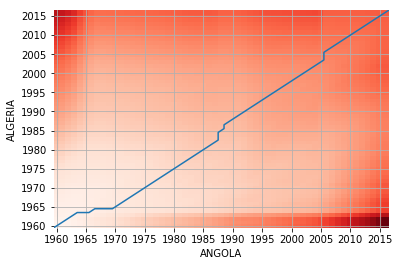

In [4]:
tick = np.arange(1960, 2017, step = 1)

for i in np.arange(1):     # replace by len(countries) if you want to map all countries against each other
    X    = data_df.iloc[:,i]
    namX = countries[i]

    for j in np.arange(2): # replace by len(countries) if you want to map all countries against each other
        Y    = data_df.iloc[:,j]
        namY = countries[j]

        if namY == namX:
            continue

        Gamma, cost, _, _ = dtw.get_accumulated_cost_matrix(X,Y)
        pstar = dtw.get_optimal_path(Gamma)

        # for visualization purposes (such that endpoint isn't cut off)
        pstar = np.vstack([pstar, [len(X)+1,len(Y)+1]]) 

        # make Gamma a df with the years as labels
        Gamma = pd.DataFrame(Gamma, index = tick, columns = tick)

        ## Plot it
        f  = plt.figure()
        ax = sns.heatmap(Gamma, linewidth = 0, cmap = 'Reds', cbar = False, xticklabels = 5, yticklabels = 5) 
        plt.plot(pstar[:,1], pstar[:,0]) # flip the columns for correct visualization
        plt.gca().invert_yaxis()
        plt.xlabel(namY)
        plt.ylabel(namX)
        plt.grid()
        plt.show()
        plt.close(f)

## DTW Clustering
### Find Clusters
Apply DTW CLustering to all countries for a given number of clusters, _K_. **NOTE: This cell may take several hours to execute for K > 2!**

In [ ]:
# requires numpy (np), pandas (pd), matplotlib.pyplot (plt), pathlib (pl), dtw_funs (dtw; written by me)

np.random.seed(252311) # there is some randomness in the DBA initialization

## 0) Import data & Initialization
core_path = "/Users/mwelz/Documents/work/ra_franses/2019/wk17/code/clusters" # parent directory to store the results in
K_set     = [1,2]  # number of clusters
n_iters   = 5      # number of DBA iterations
# import pre-processed data (index data with 1960=100 for all countries):
data_df   = pd.read_csv('/Users/mwelz/Documents/work/ra_franses/2019/wk17/data/africa_gdp_index.csv', header = 0) 



## 1) Prepare data
data_df.drop(data_df.tail(4).index,inplace=True) # drop last 4 rows (constant growth everywhere)
del data_df['DATE']                              # drop dates from data frame
countries = list(data_df)
X         = data_df.values
# remove Equatorial Guinea and Botswana (much larger scale, they will form their own cluster)
idx       = [i for i,j in enumerate(countries) if(j == "EQGUINEA" or j == "BOTSWANA")]
countries.remove("EQGUINEA")
countries.remove("BOTSWANA")
X         = np.delete(X, idx, axis=1)
X         = X.T # transpose such that the time series are contained in the rows, whereas the T periods are the colums. This is in line with tidy data as we want to cluster the series, not periods! Hence, the series are the observations!
N,P       = np.shape(X)


for K in K_set:

    clusters_dir = core_path + '/' + str(K) + 'clusters' # value-of-K-specific directory
    pl.Path(clusters_dir).mkdir(parents=True, exist_ok=True) # create a directory to store the results in

    ## 2) Apply K-Means clustering
    output     = dtw.kMeansClustering(X, K, n_iters=n_iters, max_iters=30)
    S          = output['clusters']
    centroids  = output['centroids']
    dispersion = output['totalDispersons']
    print("For K=" + str(K) + ", we have " + str(output['iterations']) + " iterations and empty was " + str( output['empty'])) # empty=0 means that during the clustering process, no empty clusters emerged
    
    ## 3) save the clusters, their centroids and their total dispersion
    np.savetxt(clusters_dir + "/clusters.csv", clusters_arr, delimiter=",") 
    np.savetxt(clusters_dir + "/centroids.csv", centroids_arr, delimiter=",")
    np.savetxt(clusters_dir + "/dispersion.csv", dispersion, delimiter=",")
    

### Visualize the Clusters
We access the results of the previous cell that have been stored in a directory.

Disperion for K=1 clusters is 11.781198583462333


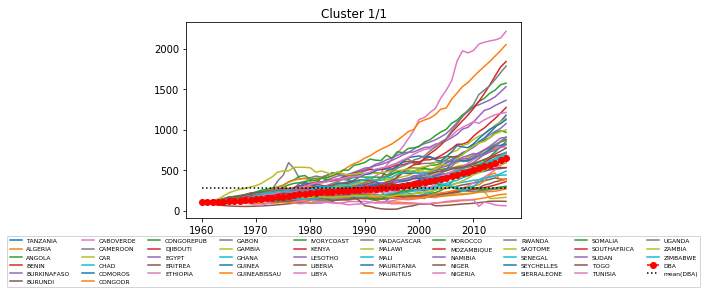

In [5]:
K = 1 # the input of K (#Clusters) that we want to visualize and is available from the previous cell. 
core_path_results = "/Users/mwelz/Documents/work/ra_franses/2019/wk17/code/clusters" # dir where results are in

# get the data
data_df   = pd.read_csv('/Users/mwelz/Documents/work/ra_franses/2019/wk17/data/africa_gdp_index.csv', header = 0) 
data_df.drop(data_df.tail(4).index,inplace=True) # drop last 4 rows (constant growth everywhere)
del data_df['DATE']                              # drop dates from data frame
countries = list(data_df)
X         = data_df.values
# remove Equatorial Guinea and Botswana (much larger scale, they will form their own cluster)
idx       = [i for i,j in enumerate(countries) if(j == "EQGUINEA" or j == "BOTSWANA")]
countries.remove("EQGUINEA")
countries.remove("BOTSWANA")
X         = np.delete(X, idx, axis=1)
X         = X.T # transpose such that the time series are contained in the rows, whereas the T periods are the colums. This is in line with tidy data as we want to cluster the series, not periods! Hence, the series are the observations!
N,T       = np.shape(X)
x         = 1960 + np.arange(T) # x-axis (for later)


# get the centroids
clusters  = pd.read_csv(core_path_results + '/' + str(K) + 'clusters/clusters.csv', header=None)
clusters  = clusters.values

# get the centroids:
centroids = pd.read_csv(core_path_results + '/' + str(K) + 'clusters/centroids.csv', header=None)
centroids = centroids.values # each column contains a centroid

# get the dispersions
dispersions = pd.read_csv(core_path_results + '/' + str(K) + 'clusters/dispersion.csv', header=None)
dispersions = dispersions.values
print("Disperion for K=" + str(K) + " clusters is " + str(np.sum(dispersions)))


S = [[] for _ in range(K)]
# store the clusters in sublists:
[S[k].extend(clusters[:,k]) for k in range(K)]

for k in range(K):
    S[k] = [int(i) for i in S[k] if str(i) != 'nan'] # clean the lists, i.e. remove NAs.
    S_k  = S[k]
    N_k  = len(S_k)
    X_k  = X[S_k,:]
    C_k  = centroids[:,k]

    countries_k = [countries[i] for i in S_k] # the countries don't contain Botswana and Equatorial Guinea anymore    
    mean_cluster = np.repeat(np.mean(C_k), T)
    countries_k.extend(('DBA', 'mean(DBA)')) 
    data = X_k.copy()
    data = np.append(data, np.reshape(C_k,(1,T)), axis=0)
    data = np.append(data, np.reshape(mean_cluster,(1,T)), axis=0)

    # create the plot of the k-th cluster:
    plots = []
    f     = plt.figure() 
    ax    = plt.subplot(111)
    for i in np.arange(N_k+2): 
        country = countries_k[i]

        if i < N_k:
            plots.append(plt.plot(x, data[i,:], label=country))
        elif i == N_k: 
            plots.append(plt.plot(x, data[i,:], '--ro', label=country))
        elif i == N_k+1:
            plots.append(plt.plot(x, data[i,:], ':k', label=country))
    
    # Shrink current axis' height by 10% on the bottom
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])

    # Put a legend below current axis
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.075), ncol=10, prop={'size': 6})
    plt.title("Cluster " + str(k+1) + "/" + str(K))
    plt.show()
    plt.close(f)

## References
- Franses, P.H. & Wiemann, T. (2018). Intertemporal Similarity of Economic Time Series. Econometric Institute Research Papers EI2018-30, Erasmus University Rotterdam, Erasmus School of Economics (ESE), Econometric Institute.
- MacQueen, J. (1967, June). Some Methods for Classification and Analysis of Multivariate Observations. In _Proceedings of the Fifth Berkeley Symposium on Mathematical Statistics and Probability_ (Vol. 1, No. 14, pp. 281-297).
- Müller, M. (2007). Dynamic Time Warping. In _Information Retrieval for Music and Motion_ (pp. 69-84).
- Petitjean, F., Ketterlin, A., & Gançarski, P. (2011). A Global Averaging Method for Dynamic Time Warping, with Applications to Clustering. Pattern Recognition, 44(3), 678-693.